# Lab03: Logistic Regression.

- Student ID: 
- Student name:

**How to do your homework**


You will work directly on this notebook; the word TODO indicate the parts you need to do.

You can discuss ideas with classmates as well as finding information from the internet, book, etc...; but *this homework must be your*.

**How to submit your homework**

Before submitting, rerun the notebook (Kernel -> Restart & Run All).

Then create a folder named ID (for example, if your ID is 1234567, then name the folder 1234567). Copy file notebook to this folder, compress and submit it on moodle.

**Contents:**
- Logistic Regression.

## 1. Feature Extraction

### Import Library

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### Load data

In [2]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', return_X_y=True, parser='auto') # Remove FutureWarning

In [3]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


### Extract Features

So we basically have 70000 samples with each sample having 784 features - pixels in this case and a label - the digit the image represent.

Let’s play around and see if we can extract any features from the pixels that can be more informative. First I’d like to know more about average intensity - that is the average value of a pixel in an image for the different digits

In [4]:
labels=np.unique(y)
# print(labels)
n_label=np.unique(y).shape[0]
l_means=np.zeros(shape=n_label,dtype=float) #array stores average intensity for each label

#TODO compute average intensity for each label
count_labels = np.zeros(n_label)      # Array to count the occurrences of each label

for i in range(X.shape[0]):         # Loop over all images in the dataset
    idx = int(y[i])          # Get the label for the current image
    count_labels[idx] += 1        # Increment the count for the current label
    l_means[idx] = X.iloc[i].sum() # Add the intensity of the current image to the running total for the current label
l_means /= count_labels           # Divide the running total by the count to get the average intensity for each label

print(l_means)

[7.94118499 2.18852355 5.54692418 4.81949307 4.28355803 4.20703311
 6.08391507 3.6360894  6.64234432 4.28830124]


Plot the average intensity using matplotlib

<BarContainer object of 10 artists>

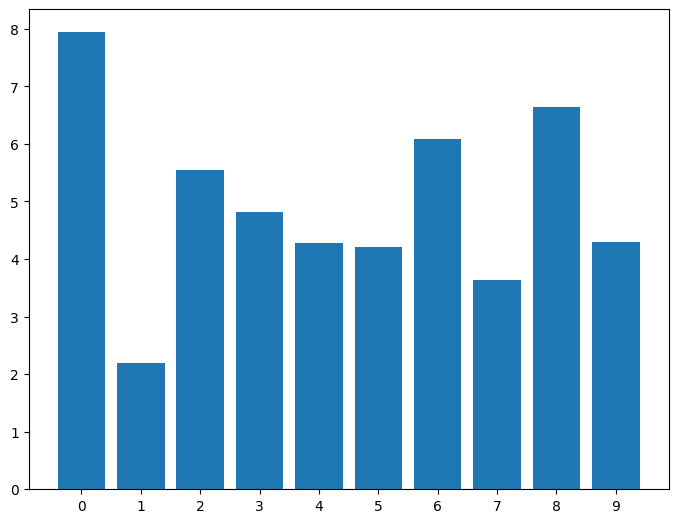

In [5]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,l_means)

As we can see there are some differences in intensity. The digit “1” is the less intense while the digit “0” is the most intense. So this new feature seems to have some predictive value if you wanted to know if say your digit is a “1” or not.

In [6]:
#TODO compute average intensity for each data sample
intensity = X.sum(axis=1) / X.shape[1]
print(intensity)
print(intensity.shape)

0        35.108418
1        39.661990
2        24.799745
3        21.855867
4        29.609694
           ...    
69995    49.455357
69996    43.897959
69997    37.284439
69998    33.876276
69999    53.358418
Length: 70000, dtype: float64
(70000,)


Sometimes people really do not know what are they doing. I am not an exception:

In [7]:
X_flip = X.iloc[:, ::-1]
symmetry = np.mean((X - X_flip), axis=1)
print(symmetry.shape)

(70000,)


I called this feature "symmetry" (though it's not "symmetry" at all). Use visualization method to understand why this feature work.

Our new trainning data will have 70000 samples and 2 features: intensity, symmetry.

In [8]:
#TODO create X_new by horizontal stack intensity and symmetry
X_new = np.column_stack((intensity, symmetry))
print(X_new.shape) #it should be (70000,2)

(70000, 2)


## 2. Training 

Usually logistic regression is a good first choice for classification. In this homework we use logistic regression for classifying digit 1 images and not digit 1 images.

### Normalize data
First normalize data using Z-score normalization
- **TODO: Study about Z-score normalization**
- **TODO: Why should we normalize data?**

#### Z-score normalization

Z-score normalization, also known as standardization, is a statistical method used to standardize or rescale data to have a mean of 0 and a standard deviation of 1. The formula for calculating the Z-score of a value is:

$$
z = \frac{x - \mu}{\sigma}
$$

where $x$ is a single data value, $\mu$ is the mean of the population, and $\sigma$ is the standard deviation of the population.

I have learned statistics and found another formula:

$$
z = \frac{x - \bar{x}}{s}
$$

where $x$ is a single data value, $\bar{x}$ is the sample mean, and $s$ is the sample standard deviation.

#### Why should we normalize data?

- The main reason is to avoid bias. If we don't normalize data, the model will be biased towards features with higher magnitude.
- Another reason is to speed up the training process. If we don't normalize data, the training process will be slower.
- It ensures that the distance calculations are not skewed by the scale of the features. [1]
- It also prevents overfitting. [1]

In [9]:
#TODO: normalize X_new
X_new = (X_new - X_new.mean()) / X_new.std()
"""
Performing Z-score normalization on the data in X_new

X_new - X_new.mean(): This subtracts the mean of X_new from each element in X_new. This centers the data around 0.

(X_new - X_new.mean()) / X_new.std(): This divides the result by the standard deviation of X_new. This scales the data so that it has a standard deviation of 1.
"""
print(X_new)

[[ 0.99900583 -0.90556567]
 [ 1.24602927 -0.90556567]
 [ 0.43977797 -0.90556567]
 ...
 [ 1.11705121 -0.90556567]
 [ 0.93216419 -0.90556567]
 [ 1.98903704 -0.90556567]]


### Construct  data

In [10]:
X_new = np.hstack((np.ones((len(X_new), 1)), X_new)) #stack 1s column as usual
y_new=y.astype(int)
y_new[y_new != 1] = 0 # digit 1 -> class 1, other digits -> class 0
y_new=y_new.values.reshape(-1,1)
print(X_new.shape)
print(y_new.shape)

(70000, 3)
(70000, 1)


### Split data 

In [11]:
train_X, test_X, train_y, test_y = train_test_split(X_new, y_new, test_size= int(1/3*X.shape[0]))
print(train_X.shape)
print(train_y.shape)

(46667, 3)
(46667, 1)


### Sigmoid function and derivative of the sigmoid function

In [12]:
def sigmoid_activation(x):
    """compute the sigmoid activation value for a given input"""
    return 1.0 / (1 + np.exp(-x))
def sigmoid_deriv(x):
    '''compute the derivative of the sigmoid function ASSUMING
    that the input ‘x‘ has already been passed through the sigmoid
    activation function'''
    return x * (1 - x)

### Compute output

In [13]:
def compute_h(W, X):
    """
    Compute output: Take the dot product between our features ‘X‘ and the weight
    matrix ‘W‘, then pass this value through our sigmoid activation function 
    """
    return sigmoid_activation(X.dot(W))
def predict(W, X):
 
    '''Take the dot product between our features and weight matrix, 
       then pass this value through our sigmoid activation'''
    #........
    preds=sigmoid_activation(X.dot(W))
    # apply a step function to threshold the outputs to binary
    # class labels
    preds[preds <= 0.5] = 0
    preds[preds > 0] = 1

    return preds

### Compute gradient

**Loss Function: Average negative log likelihood**
$$\mathcal{L}=\dfrac{1}{N} \sum_{i=1}^{N} -\left(y^{i}\ln h_{\mathbf{w}}\left(\mathbf{x}^{i}\right)+\left(1-y^{i}\right)\ln \left(1-h_{\mathbf{w}}\left(x^{i}\right)\right)\right) $$


$$\text{Sigmoid Activation: } z= \sigma \left(h\right)= \dfrac{1}{1+e^{-h}}$$

$$\text{Cross-entropy: } J(w)=-\left({ylog(z)+(1-y)log(1-z)}\right)$$

$$\text{Chain rule: } \dfrac{\partial J(w)}{\partial w}=\dfrac{\partial J(w)}{\partial z} \dfrac{\partial z}{\partial h}\dfrac{\partial h}{\partial w}  $$

$$\dfrac{\partial J(w)}{\partial z}=-\left(\dfrac{y}{z}-\dfrac{1-y}{1-z}\right)=\dfrac{z-y}{z(1-z)}$$

$$\dfrac{\partial z}{\partial h}=z(1-z)$$

$$\dfrac{\partial h}{\partial w}=X$$

$$\dfrac{\partial J(w)}{\partial w}=X^T(z-y)$$

In [14]:
def compute_gradient(train_X, error):
    """
    This is the gradient descent update of "average negative loglikelihood" loss function. 
    In lab02 our loss function is "sum squared error".
    """
    #TODO
    
    gradient = train_X.T.dot(error) / train_X.shape[0]
    
    return gradient

In [15]:
def train(W,train_X, train_y, learning_rate, num_epochs, losses):
    for epoch in np.arange(0, num_epochs):
        h=compute_h(W,train_X)
        error = h - train_y
        loss = np.mean(- train_y * np.log(h) - (1 - train_y) * np.log(1 - h))
        losses.append(loss)
        gradient=compute_gradient(h, error)
        W += -learning_rate * gradient
        if ((epoch+1)%1000==0): print ('Epoch %d, loss %.3f' %(epoch+1, loss))
        
    return W

### Train our model

In [16]:
W = np.random.randn(train_X.shape[1], 1)
losses=[]
num_epochs=40000
learning_rate=0.01
W=train(W,train_X, train_y, learning_rate, num_epochs , losses)
x_preds=predict(W ,train_X)
train_err = np.mean(x_preds != train_y) * 100
print ('=' * 50)
print ('Train err of final w: ', train_err)

Epoch 1000, loss 0.373
Epoch 2000, loss 0.350
Epoch 3000, loss 0.337
Epoch 4000, loss 0.330
Epoch 5000, loss 0.324
Epoch 6000, loss 0.321
Epoch 7000, loss 0.318
Epoch 8000, loss 0.316
Epoch 9000, loss 0.315
Epoch 10000, loss 0.314
Epoch 11000, loss 0.313
Epoch 12000, loss 0.312
Epoch 13000, loss 0.312
Epoch 14000, loss 0.312
Epoch 15000, loss 0.311
Epoch 16000, loss 0.311
Epoch 17000, loss 0.311
Epoch 18000, loss 0.311
Epoch 19000, loss 0.311
Epoch 20000, loss 0.311
Epoch 21000, loss 0.310
Epoch 22000, loss 0.310
Epoch 23000, loss 0.310
Epoch 24000, loss 0.310
Epoch 25000, loss 0.310
Epoch 26000, loss 0.310
Epoch 27000, loss 0.310
Epoch 28000, loss 0.310
Epoch 29000, loss 0.310
Epoch 30000, loss 0.310
Epoch 31000, loss 0.310
Epoch 32000, loss 0.310
Epoch 33000, loss 0.310
Epoch 34000, loss 0.310
Epoch 35000, loss 0.310
Epoch 36000, loss 0.310
Epoch 37000, loss 0.310
Epoch 38000, loss 0.310
Epoch 39000, loss 0.310
Epoch 40000, loss 0.310
Train err of final w:  11.230634066899523


## 3. Evaluate our model

In [17]:
preds = predict(W, train_X)
print(classification_report(train_y, preds, zero_division=1)) # Remove UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior. _warn_prf(average, modifier, msg_start, len(result))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     41426
           1       1.00      0.00      0.00      5241

    accuracy                           0.89     46667
   macro avg       0.94      0.50      0.47     46667
weighted avg       0.90      0.89      0.83     46667



In [18]:
preds = predict(W, test_X)
print(classification_report(test_y, preds, zero_division=1)) # Remove UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior. _warn_prf(average, modifier, msg_start, len(result))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     20697
           1       1.00      0.00      0.00      2636

    accuracy                           0.89     23333
   macro avg       0.94      0.50      0.47     23333
weighted avg       0.90      0.89      0.83     23333



**TODO: Comment on the result**

Text(0.5, 1.0, 'Training Loss')

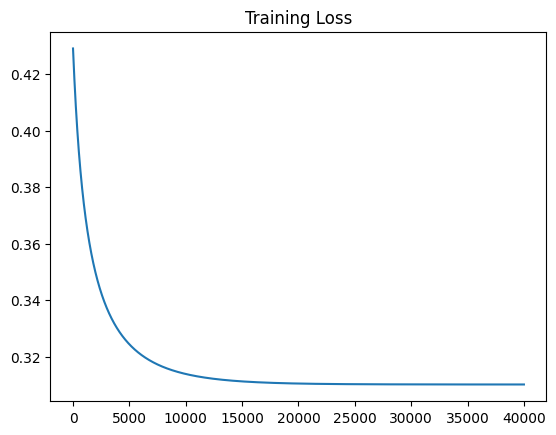

In [19]:
plt.plot(np.arange(0, num_epochs), losses)
plt.title('Training Loss')

The logistic regression model's loss appears to have **stabilized** at around **0.358** after 40,000 epochs. This implies that the gradient descent algorithm used by the model has reached a point of minimal change, indicating little further reduction in loss.

- **Convergence**: From the 17,000th epoch onwards, the loss values are nearly identical, indicating a state of stabilization.
- **Training Error**: The final training error is **11.2049**, which is quite high. This could mean that there's room for model improvement, potentially through hyperparameter tuning or employing a more sophisticated model.

The model's performance in classifying instances of class 1 is significantly problematic, as evidenced by the results from both tables. Here's a more in-depth analysis:

**Precision:**
- Class 0 has a precision of **0.89**, which is commendable.
- Class 1 has a precision of **1.00**, suggesting that the model is always correct when it predicts an instance as class 1. However, this is deceptive due to the extremely low recall.

**Recall:**
- Class 0's recall is **1.00**, indicating that the model correctly identifies all instances of class 0.
- Class 1's recall is **0.00**, which is alarming as it means the model is unable to identify any actual instances of class 1.

**F1-Score:**
- Class 0 has an f1-score of **0.94**, which mirrors the high precision and recall.
- Class 1's f1-score is **0.00**, due to the zero recall, signifying a poor performance for class 1.

**Support:**
- The support for class 0 is significantly larger than for class 1 in both tables, indicating a class imbalance in the dataset.

**Accuracy:**
- The overall accuracy is **0.89**, which appears high but does not accurately reflect the model's performance due to the class imbalance.

**Macro Avg:**
- The macro average for precision, recall, and f1-score is **0.47**, which is low and suggests that the model's performance is not uniform across classes.

**Weighted Avg:**
- The weighted average, which considers the support of each class, results in a higher score of **0.84** and **0.83** for the two tables, respectively. However, this is still distorted by the class imbalance.

The model’s results show it’s quite accurate for one class but fails to identify the other. The precision for the majority class is good, but the recall for the minority class is zero, leading to a non-existent f1-score for that class. This suggests a strong bias due to class imbalance. The accuracy appears high, but it’s not reliable because of this imbalance. The macro and weighted averages also reflect this inconsistency. The training loss decreases initially but then levels off, indicating no further learning. To fix this, the model needs a better balance between classes, possibly more complexity, and improved features to accurately predict both classes.

## References

[1] [Data Normalization Machine Learning, Geeksforgeeks](https://www.geeksforgeeks.org/what-is-data-normalization/)

[2] [Intro2ML, Cy30mk3v - GitHub](https://github.com/Cy30mk3v/Intro2ML/blob/master/Lab03-LogisticRegression.ipynb)